In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install geopandas
# !pip install pysheds
# !pip install mplleaflet
# !pip install IPython
# !pip install simplekml

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
from pyproj import CRS
%matplotlib inline
from IPython.display import IFrame


In [8]:
grid = Grid.from_raster('D:\IIITMK+GIS\REPOS\GIS_repo\DISTRICT_TIF\m_idukki1.tif', data_name='dem')

In [5]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    # plt.imshow(data, cmap=cmap)

    plt.colorbar(label=label)
    plt.grid()

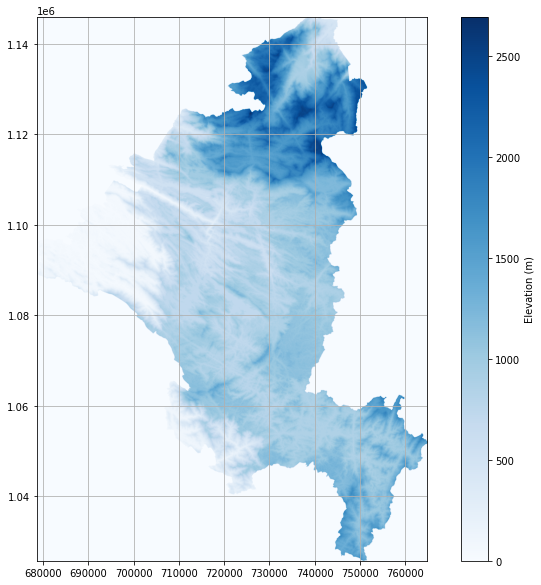

In [6]:
plotFigure(grid.dem, 'Elevation (m)')

In [7]:
depressions = grid.detect_depressions('dem')


Text(0.5, 1.0, 'Depressions')

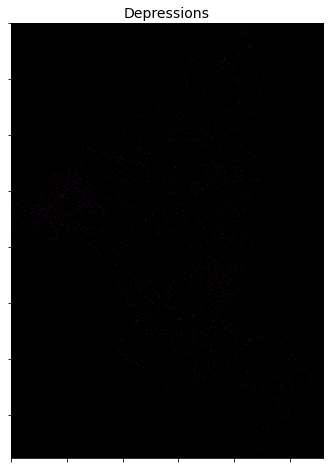

In [8]:

# Plot pits
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(depressions, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Depressions', size=14)

In [9]:
grid.fill_depressions(data='dem', out_name='flooded_dem')


In [10]:
flats = grid.detect_flats('flooded_dem')


Text(0.5, 1.0, 'Flats')

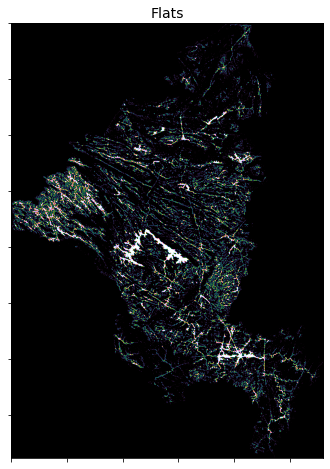

In [11]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [12]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')


In [13]:
flats_test = grid.detect_flats('inflated_dem')


Text(0.5, 1.0, 'Flats')

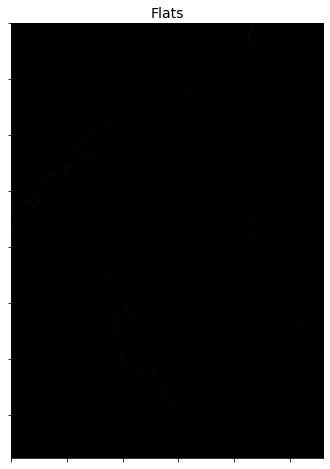

In [14]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats_test, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [15]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [16]:
# Compute flow direction based on corrected DEM
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)


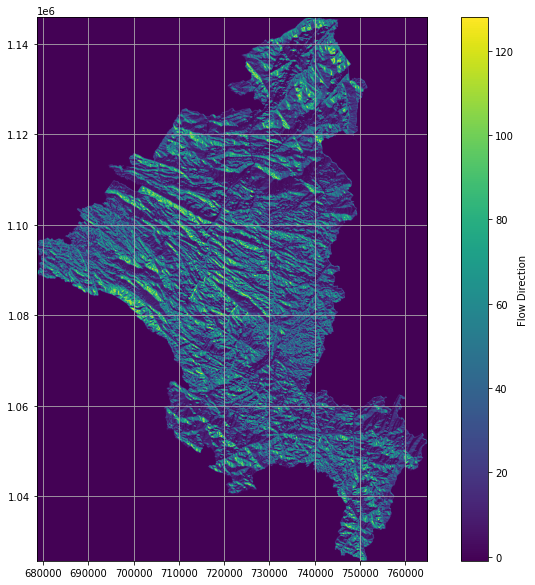

In [17]:
plotFigure(grid.dir, 'Flow Direction', 'viridis')

In [18]:
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

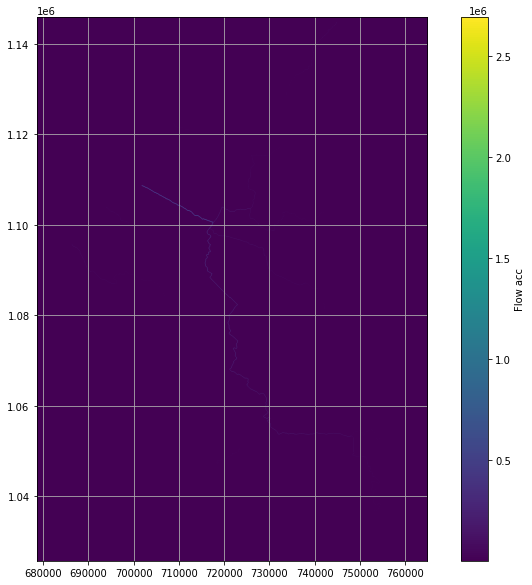

In [19]:
plotFigure(grid.acc, 'Flow acc', 'viridis')

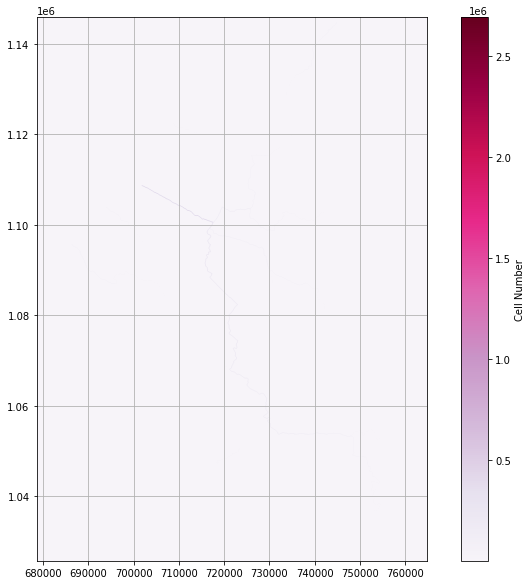

In [20]:
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [21]:
# Delineate catchment at point of high accumulation
y, x = np.unravel_index(np.argsort(grid.acc.ravel())[-2], grid.acc.shape)



In [1]:
grid.catchment(x, y, data='dir', out_name='catch',
               dirmap=dirmap, xytype='index')

NameError: name 'grid' is not defined

In [ ]:
streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

In [ ]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [2]:
#save geojson as separate file
saveDict(streams,'streams.geojson')

NameError: name 'saveDict' is not defined

In [9]:
streamNet = gpd.read_file('streams.geojson')
# streamNet.crs = {'init' :'epsg:32613'}
streamNet.crs = CRS('epsg:32613')

<AxesSubplot:title={'center':'Catchment boundary (vector)'}>

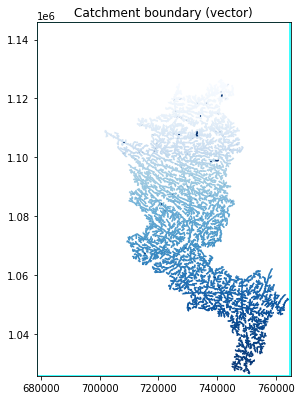

In [10]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

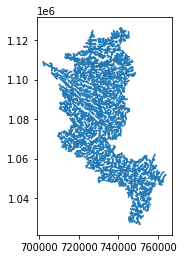

In [11]:
ax = streamNet.plot()


In [15]:
mplleaflet.show(fig=ax.figure, crs='epsg:32613' , tiles = 'esri_aerial')

TypeError: type object argument after ** must be a mapping, not str

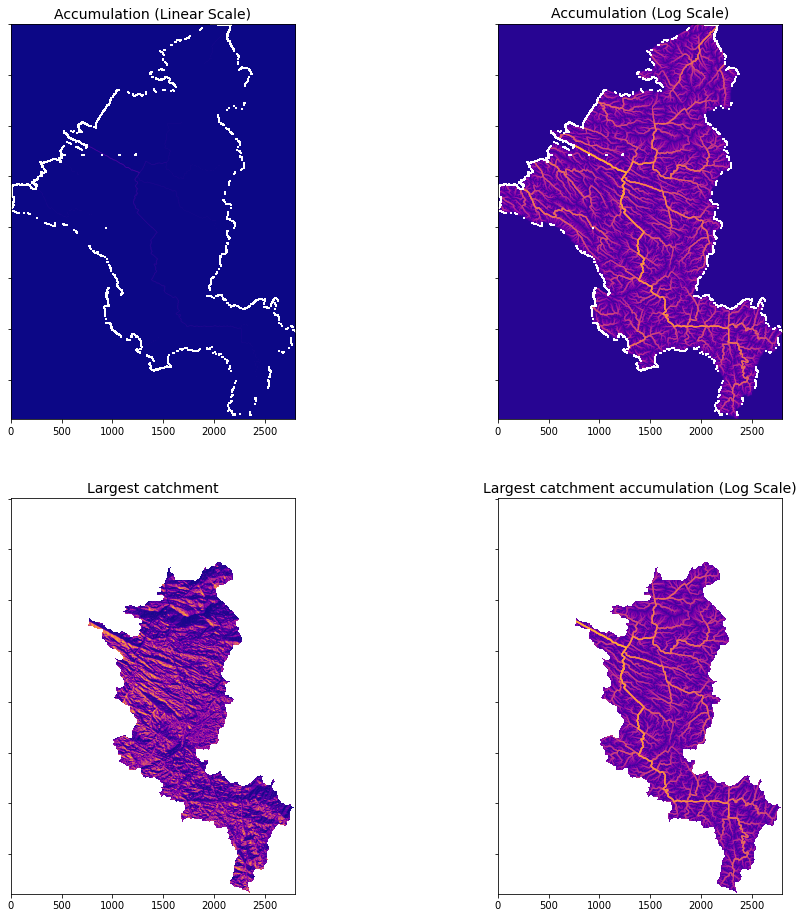

In [ ]:
# Plot accumulation and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0,0].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma')
ax[0,1].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))
ax[1,0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap='plasma')
ax[1,1].imshow(np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))

ax[0,0].set_title('Accumulation (Linear Scale)', size=14)
ax[0,1].set_title('Accumulation (Log Scale)', size=14)
ax[1,0].set_title('Largest catchment', size=14)
ax[1,1].set_title('Largest catchment accumulation (Log Scale)', size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])

In [ ]:
# grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)

In [ ]:
# plotFigure(grid.dir,'Flow Directiom','viridis')

In [ ]:
# Specify pour point
# x, y = 700000,1125751.682

# Delineate the catchment
# grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
              #  recursionlimit=15000, xytype='label', nodata_out=0)

In [ ]:
# Clip the bounding box to the catchment
# grid.clip_to('catch')

In [ ]:
# Get a view of the catchment
# demView = grid.view('dem', nodata=np.nan)

In [ ]:
# plotFigure(demView,'Elevation')

In [ ]:
#export selected raster
# grid.to_raster(demView, 'clippedElevations.tif')

In [ ]:
# grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [ ]:
# accView = grid.view('acc', nodata=np.nan)
# plotFigure(accView,"Cell Number",'PuRd')

In [ ]:
# streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
# streams["features"][:2]

In [ ]:
# def saveDict(dic,file):
#     f = open(file,'w')
#     f.write(str(dic))
#     f.close()

In [ ]:
# #save geojson as separate file
# saveDict(streams,'streams.geojson')

In [ ]:
# streamNet = gpd.read_file('streams.geojson')
# streamNet.crs = {'init' :'epsg:32613'}
# streamNet.crs = CRS('epsg:32613')

In [ ]:
# # The polygonize argument defaults to the grid mask when no arguments are supplied
# shapes = grid.polygonize()

# # Plot catchment boundaries
# fig, ax = plt.subplots(figsize=(6.5, 6.5))

# for shape in shapes:
#     coords = np.asarray(shape[0]['coordinates'][0])
#     ax.plot(coords[:,0], coords[:,1], color='cyan')
    
# ax.set_xlim(grid.bbox[0], grid.bbox[2])
# ax.set_ylim(grid.bbox[1], grid.bbox[3])
# ax.set_title('Catchment boundary (vector)')
# gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

In [ ]:
# ax = streamNet.plot()

In [ ]:
# mplleaflet.display(fig=ax.figure, epsg=32613, tiles='esri_aerial')

In [ ]:
# IFrame(streamNet.crs, width=700, height=350, tiles='esri_aerial')

In [ ]:
IFrame('http://stackoverflow.org', width=500, height=350)


In [ ]:
# # The polygonize argument defaults to the grid mask when no arguments are supplied
# shapes = grid.polygonize()

# # Plot catchment boundaries
# fig, ax = plt.subplots(figsize=(6.5, 6.5))

# for shape in shapes:
#     coords = np.asarray(shape[0]['coordinates'][0])
#     ax.plot(coords[:,0], coords[:,1], color='cyan')
    
# ax.set_xlim(grid.bbox[0], grid.bbox[2])
# ax.set_ylim(grid.bbox[1], grid.bbox[3])
# ax.set_title('Catchment boundary (vector)')
# gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

# #ax = streamNet.plot()
# mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')

In [11]:
import mplleaflet
import matplotlib.pyplot as plt

lats = [54.3256, 53.2692, 53.8242, 53.2178]
lons = [2.9356, 3.6278, 2.9453, 3.2203] 

fig = plt.figure()    #This is missing in your code.
plt.plot(lons, lats, 'r.')

#And after this call the funtion:

mplleaflet.display(fig=fig)
#It will display the matplotlib object created by plot function